<a href="https://colab.research.google.com/github/newstage75/ML_study/blob/master/%E6%9C%80%E7%9F%ADPytorch/%EF%BC%98%E7%AB%A0MNIST%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%9F%E6%95%B0%E5%AD%97%E8%AA%8D%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#８章MNISTを使った数字認識

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [3]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

###GPU利用

####GPU利用のルール

1.テンソル変数はデータがCPU/GPU上のどちらにあるのかを属性として持っている

2.CPUとGPU間のデータはto関数で転送する

3.2つの変数が両方ともGPU上にある場合、演算はGPUで行われる

4.変数の片方がCPU、もう一方がGPUの場合はエラーになる。

In [6]:
#デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
#テスト用tensor変数x, y
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


In [8]:
#変数xをGPUに送る
x = x.to(device)

print('x: ', x.device)
print('y: ', y.device)

x:  cuda:0
y:  cpu


In [9]:
#この状態の計算はエラー
z = x * y

RuntimeError: ignored

In [11]:
#変数yもGPUに送る
y = y.to(device)

z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000], device='cuda:0')


In [12]:
#データ準備1(データセットによる読み込み)

#ライブラリインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = './data'

train_set0 = datasets.MNIST(
    #元データダウンロード先の指定
    root = data_root,
    #訓練データか検証データか
    train = True,
    #元データがない場合にダウンロードするか
    download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [18]:
#ダウンロードしたの確認

!ls -lR ./data/MNIST

./data/MNIST:
total 4
drwxr-xr-x 2 root root 4096 May 22 04:41 raw

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 May 22 04:41 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 May 22 04:41 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 May 22 04:41 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 May 22 04:41 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 May 22 04:41 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 May 22 04:41 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 May 22 04:41 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 May 22 04:41 train-labels-idx1-ubyte.gz


In [20]:
#データの件数の確認
print('データ件数: ', len(train_set0))

#最初の要素の取得
image, label = train_set0[0]

print('入力データの型:', type(image))
print('正解データの型:', type(label))

データ件数:  60000
入力データの型: <class 'PIL.Image.Image'>
正解データの型: <class 'int'>


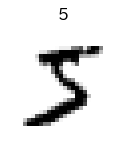

In [21]:
#入力データの画像表示
plt.figure(figsize=(2,3))
plt.title(f'{label}')
plt.imshow(image,cmap='gray_r')
plt.axis('off')
plt.show()

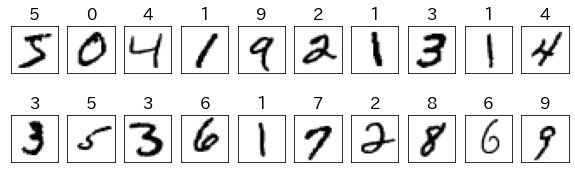

In [24]:
#正解データ付きで、最初の20個のイメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
  ax = plt.subplot(2, 10, i + 1)

  #imageとlabelの取得
  image, label = train_set0[i]

  #イメージ表示
  plt.imshow(image, cmap='gray_r')
  ax.set_title(f'{label}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
#データ前処理
#Step1 ToTensorの利用

import torchvision.transforms as transforms

transform1 = transforms.Compose([
        #　データのTensor化
        transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root=data_root, train=True, download=True,
    transform = transform1)

In [26]:
#変換結果の確認
image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([1, 28, 28])
最小値:  tensor(0.)
最大値:  tensor(1.)


In [27]:
#Step2 Notmalizeの利用
transform2 = transforms.Compose([
        #データのTensor化
        transforms.ToTensor(),

        #データの正規化
        transforms.Normalize(0.5, 0.5),
])

train_set2 = datasets.MNIST(
    root = data_root, train = True, download = True,
    transform = transform2)

In [28]:
#変換結果の確認
image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([1, 28, 28])
最小値:  tensor(-1.)
最大値:  tensor(1.)


In [30]:
#Step3 Lambdaを利用して1階テンソル化
transform3 = transforms.Compose([
        # データのTensor化
        transforms.ToTensor(),

        #データの正規化
        transforms.Normalize(0.5, 0.5),

        #Tensorの1階テンソル化
        transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root, train = True,
    download=True, transform=transform3)

In [31]:
#変換結果の確認
image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(-1.)
最大値:  tensor(1.)
